In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from Bio import SeqIO
from Bio.SeqUtils import ProtParam
#from Bio.Alphabet import  generic_protein
#from Bio.Seq import Seq
import numpy as np

def extract_pssm_features(pssm_file):
    # read in PSSM file
    with open(pssm_file) as f:
        pssm_lines = f.readlines()[3:-6]

    # extract features
    features = []
    for line in pssm_lines:
        values = line.split()[22:42]
        features.append(list(map(float, values)))
    features = np.array(features)

    return features
# Convert PSSM features to a numpy array
X = np.array(pssm_features)

# Convert labels to a numpy array
y = np.array(labels)
rom Bio import SeqIO
import numpy as np

def extract_fasta_features(fasta_file):
    # read in FASTA sequence
    fasta_record = SeqIO.read("/content/Plant_sequences.fasta", "fasta")
    seq = str(fasta_record.seq)

    # compute features
    hydrophobicity = []
    polarity = []
    charge = []
    for aa in seq:
        # compute hydrophobicity feature
        hydrophobicity.append(hydrophobicity_dict[aa])

        # compute polarity feature
        polarity.append(polarity_dict[aa])

        # compute charge feature
        charge.append(charge_dict[aa])

    # combine features into a single vector
    features = np.hstack((hydrophobicity.reshape(-1, 1), polarity.reshape(-1, 1), charge.reshape(-1, 1)))

    return features
print(features)

SyntaxError: invalid syntax (<ipython-input-1-4461f208e7e0>, line 29)

**CNN RBF Bi-LSTM**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the CNN layers for feature extraction
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_features.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten()
])

# Reshape the data for CNN input
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Extract features using CNN layers
train_features_cnn = cnn_model.predict(train_features_cnn)
test_features_cnn = cnn_model.predict(test_features_cnn)

# Define the RBF network (same as provided)
# Define the RBF network
class RBFNet:
    def __init__(self, input_dim, output_dim, hidden_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.hidden_dim)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Calculate the width parameter for the RBFs
        dmax = np.max([np.linalg.norm(self.centers[i] - self.centers[j]) for i in range(self.hidden_dim) for j in range(self.hidden_dim)])
        self.sigma = dmax / np.sqrt(2 * self.hidden_dim)

        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Solve for the weights using least squares regression
        self.weights = np.linalg.lstsq(X_transformed, y, rcond=None)[0]

    def predict(self, X):
        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Perform the prediction
        return np.dot(X_transformed, self.weights)

    def rbf(self, x, c):
        return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * self.sigma ** 2))

# Create the RBF network
rbf = RBFNet(input_dim=train_features_cnn.shape[1], output_dim=1, hidden_dim=50)

# Fit the RBF network on the CNN-extracted features
rbf.fit(train_features_cnn, train_labels)

# Predict using RBF network
train_rbf_predictions = rbf.predict(train_features_cnn)
test_rbf_predictions = rbf.predict(test_features_cnn)

# Concatenate RBF predictions with CNN-extracted features
train_features_with_rbf = np.concatenate((train_features_cnn, train_rbf_predictions.reshape(-1, 1)), axis=1)
test_features_with_rbf = np.concatenate((test_features_cnn, test_rbf_predictions.reshape(-1, 1)), axis=1)

# Reshape the data for Bi-LSTM input
train_features_with_rbf = train_features_with_rbf.reshape(train_features_with_rbf.shape[0], train_features_with_rbf.shape[1], 1)
test_features_with_rbf = test_features_with_rbf.reshape(test_features_with_rbf.shape[0], test_features_with_rbf.shape[1], 1)

# Define the Bi-LSTM network for classification
bi_lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(train_features_with_rbf.shape[1], train_features_with_rbf.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])

# Compile the Bi-LSTM network
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM network
bi_lstm_model.fit(train_features_with_rbf, train_labels, epochs=5, validation_data=(test_features_with_rbf, test_labels))

# Evaluate the Bi-LSTM model on the training and test data
train_loss, train_accuracy = bi_lstm_model.evaluate(train_features_with_rbf, train_labels)
test_loss, test_accuracy = bi_lstm_model.evaluate(test_features_with_rbf, test_labels)

print("Hybrid Model (CNN + RBF + Bi-LSTM):")
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
# Evaluate the Bi-LSTM model on the test data and obtain predictions
test_predictions = bi_lstm_model.predict(test_features_with_rbf)
test_predictions = (test_predictions > 0.5).astype(int)

# Compute the confusion matrix for the test predictions
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Hybrid Model (CNN + RBF + Bi-LSTM)")
plt.show()

print("Hybrid Model Confusion Matrix:")
print(conf_matrix)
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]
true_negative = conf_matrix[0, 0]
false_negative = conf_matrix[1, 0]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

36/36 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch 1/5
141/141 [==============================] - 6989s 49s/step - loss: 0.6195 - accuracy: 0.6891 - val_loss: 0.6113 - val_accuracy: 0.6922
Epoch 2/5
 78/141 [===============>..............] - ETA: 50:04 - loss: 0.6038 - accuracy: 0.6911

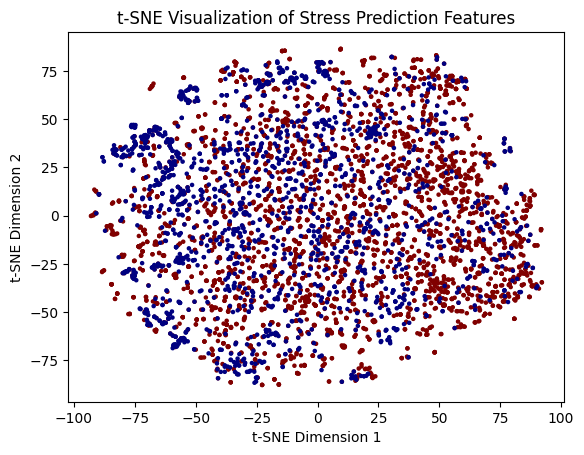

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv("/content/stressinput.csv", header=None)
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Apply t-SNE for manifold learning
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plot the manifold
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='jet', s=5)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title('t-SNE Visualization of Stress Prediction Features')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
pip install MDA-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=aac8220f44bb602a829092f76f3c94eb629d706981d231bc3287c3b0132217cd
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


36/36 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


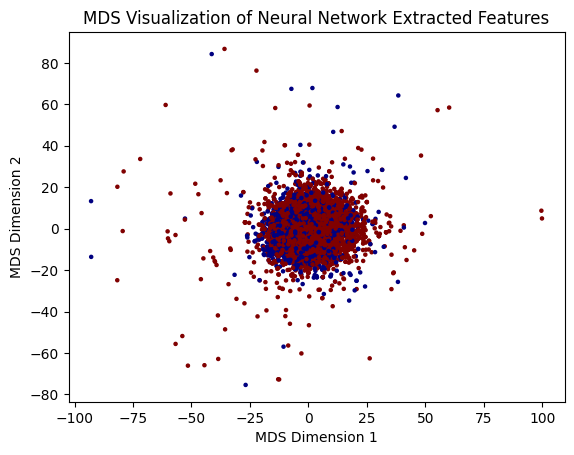

In [ ]:
#a simple feedforward neural network is used for feature extraction
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a simple feedforward neural network for 1D input
input_dim = train_features.shape[1]
output_dim = train_features.shape[1]  # Set the output dimension to match the input dimension

model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim)  # Adjust the output dimension
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training data
model.fit(train_features, train_features, epochs=10, batch_size=32, verbose=0)

# Extract features using the trained model
train_features_nn = model.predict(train_features)
test_features_nn = model.predict(test_features)

# Perform Manifold Discovery and Analysis (MDA)
mds = MDS(n_components=2, random_state=42)
train_features_mds = mds.fit_transform(train_features_nn)

# Visualize the MDA results
plt.scatter(train_features_mds[:, 0], train_features_mds[:, 1], c=train_labels, cmap='jet', s=5)
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title('MDS Visualization of Neural Network Extracted Features')
plt.show()


141/141 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


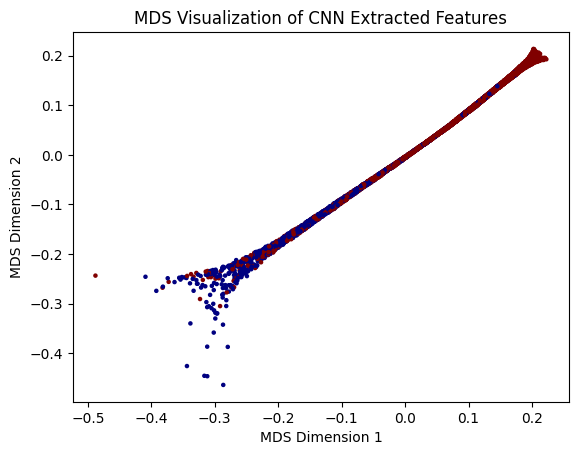

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Reshape the data for CNN input
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Create a simple CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_features_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification, adjust for your task
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
model.fit(train_features_cnn, train_labels, epochs=10, batch_size=32, verbose=0)

# Extract features using the trained CNN model
extracted_features = model.predict(train_features_cnn)

# Perform Manifold Discovery and Analysis (MDA)
mds = MDS(n_components=2, random_state=42)
extracted_features_mds = mds.fit_transform(extracted_features)

# Visualize the MDA results
plt.scatter(extracted_features_mds[:, 0], extracted_features_mds[:, 1], c=train_labels, cmap='jet', s=5)
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title('MDS Visualization of CNN Extracted Features')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


141/141 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


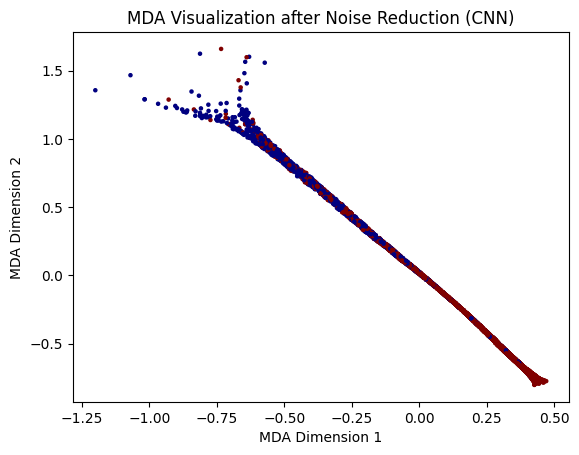

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Identify and handle outliers using RobustScaler
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Reshape the data for CNN input
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Create a simple CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_features_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification, adjust for your task
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
model.fit(train_features_cnn, train_labels, epochs=10, batch_size=32, verbose=0)

# Extract features using the trained CNN model
extracted_features = model.predict(train_features_cnn)

# Perform Robust Scaling on the extracted features
scaler_extracted = RobustScaler()
extracted_features_scaled = scaler_extracted.fit_transform(extracted_features)

# Perform PCA for noise reduction
pca = PCA()
extracted_features_pca = pca.fit_transform(extracted_features_scaled)

# Perform Manifold Discovery and Analysis (MDA)
mds = MDS(n_components=2, random_state=42)
extracted_features_mds = mds.fit_transform(extracted_features_pca)

# Visualize the MDA results after noise reduction
plt.scatter(extracted_features_mds[:, 0], extracted_features_mds[:, 1], c=train_labels, cmap='jet', s=5)
plt.xlabel("MDA Dimension 1")
plt.ylabel("MDA Dimension 2")
plt.title('MDA Visualization after Noise Reduction (CNN)')
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Load your CSV file
csv_file_path = '/content/stressinput.csv'
df = pd.read_csv(csv_file_path)

# Extract features (X) and labels (Y) from the DataFrame
# Modify this based on the structure of your CSV file
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

# Save the data as NumPy arrays
np.save('features.npy', X)
np.save('labels.npy', Y)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from keras.applications import DenseNet201
from keras.models import Model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt

# Number of neighbors in MDA analyses
neighborNum = 5

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense
from keras.utils import to_categorical

# Load your dataset
# Assuming your CSV file has features in columns 0 to (n-2) and target values in the last column (n-1)
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_scaled, labels_one_hot, test_size=0.2, random_state=42)

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features.shape[1], 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data for 1D CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
model.fit(X_train_reshaped, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, Y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
127/127 [==============================] - 5s 32ms/step - loss: 0.6235 - accuracy: 0.6898 - val_loss: 0.6247 - val_accuracy: 0.6822
Epoch 2/10
127/127 [==============================] - 4s 29ms/step - loss: 0.6200 - accuracy: 0.6898 - val_loss: 0.6244 - val_accuracy: 0.6822
Epoch 3/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6153 - accuracy: 0.6898 - val_loss: 0.6385 - val_accuracy: 0.6822
Epoch 4/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6158 - accuracy: 0.6898 - val_loss: 0.6265 - val_accuracy: 0.6822
Epoch 5/10
127/127 [==============================] - 4s 30ms/step - loss: 0.6161 - accuracy: 0.6898 - val_loss: 0.6226 - val_accuracy: 0.6822
Epoch 6/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6143 - accuracy: 0.6898 - val_loss: 0.6247 - val_accuracy: 0.6822
Epoch 7/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6138 - accuracy: 0.6898 - val_loss: 0.6221 - val_accuracy: 0.6822

Epoch 1/10
127/127 [==============================] - 5s 32ms/step - loss: 0.5977 - accuracy: 0.6953 - val_loss: 0.5824 - val_accuracy: 0.7067
Epoch 2/10
127/127 [==============================] - 4s 31ms/step - loss: 0.5588 - accuracy: 0.7230 - val_loss: 0.5811 - val_accuracy: 0.7267
Epoch 3/10
127/127 [==============================] - 4s 28ms/step - loss: 0.5510 - accuracy: 0.7262 - val_loss: 0.5641 - val_accuracy: 0.7133
Epoch 4/10
127/127 [==============================] - 6s 45ms/step - loss: 0.5403 - accuracy: 0.7292 - val_loss: 0.5517 - val_accuracy: 0.7289
Epoch 5/10
127/127 [==============================] - 3s 26ms/step - loss: 0.5381 - accuracy: 0.7428 - val_loss: 0.5554 - val_accuracy: 0.7311
Epoch 6/10
127/127 [==============================] - 4s 29ms/step - loss: 0.5237 - accuracy: 0.7467 - val_loss: 0.5569 - val_accuracy: 0.7200
Epoch 7/10
127/127 [==============================] - 4s 29ms/step - loss: 0.5212 - accuracy: 0.7457 - val_loss: 0.5190 - val_accuracy: 0.7511

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


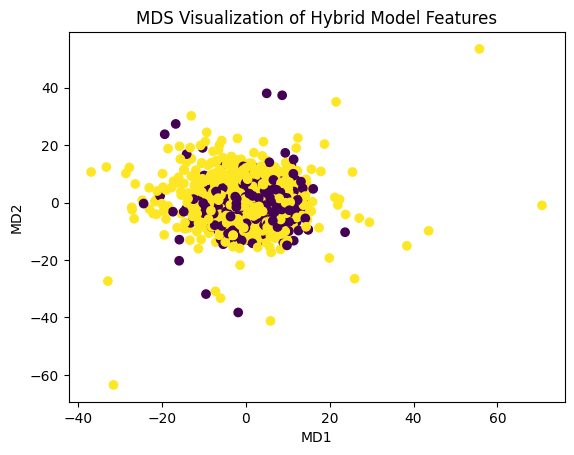

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input, concatenate
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
# Assuming your CSV file has features in columns 0 to (n-2) and target values in the last column (n-1)
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_scaled, labels_one_hot, test_size=0.2, random_state=42)

# Define the 1D CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(features.shape[1], 1)))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(GlobalAveragePooling1D())
model_cnn.add(Dense(256, activation='relu'))

# Define a simple neural network (you can replace this with a part of GoogleNet)
input_nn = Input(shape=(features.shape[1],))
dense_nn = Dense(128, activation='relu')(input_nn)

# Concatenate outputs of the CNN and the neural network
merged = concatenate([model_cnn.output, dense_nn])

# Output layer
output_layer = Dense(num_classes, activation='softmax')(merged)

# Create the hybrid model
model_hybrid = Model(inputs=[model_cnn.input, input_nn], outputs=output_layer)
model_hybrid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data for 1D CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the hybrid model
model_hybrid.fit([X_train_reshaped, X_train], Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the hybrid model on the test set
test_loss, test_accuracy = model_hybrid.evaluate([X_test_reshaped, X_test], Y_test)
print("Test Accuracy:", test_accuracy)

# Extract features for MDA from the model
feature_extraction_model = Model(inputs=model_hybrid.input, outputs=model_hybrid.layers[-2].output)
features_extracted = feature_extraction_model.predict([X_test_reshaped, X_test])

# Apply MDS for dimensionality reduction
mds = MDS(n_components=2)
features_2d = mds.fit_transform(features_extracted)

# Plot MDS results
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='viridis')
plt.title('MDS Visualization of Hybrid Model Features')
plt.xlabel('MD1')
plt.ylabel('MD2')
plt.show()


In [ ]:
#simple and custom densenet architecture
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Define the custom DenseNet-like architecture
def create_custom_densenet(input_shape, num_dense_blocks=3, num_layers_per_block=3, growth_rate=32):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_dense_blocks):
        for _ in range(num_layers_per_block):
            # Dense layer
            x = Dense(growth_rate, activation='relu')(x)
            # Concatenate with previous layers
            x = concatenate([x, input_layer])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Reshape features to simulate an image
features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Create the custom DenseNet-like model
input_shape = (features_scaled.shape[1], 1)
model_densenet = create_custom_densenet(input_shape=input_shape)

model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_densenet.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model_densenet.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
127/127 [==============================] - 7s 31ms/step - loss: 0.6230 - accuracy: 0.6898 - val_loss: 0.6260 - val_accuracy: 0.6822
Epoch 2/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6175 - accuracy: 0.6898 - val_loss: 0.6228 - val_accuracy: 0.6822
Epoch 3/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6146 - accuracy: 0.6898 - val_loss: 0.6225 - val_accuracy: 0.6822
Epoch 4/10
127/127 [==============================] - 3s 21ms/step - loss: 0.6137 - accuracy: 0.6898 - val_loss: 0.6243 - val_accuracy: 0.6822
Epoch 5/10
127/127 [==============================] - 3s 26ms/step - loss: 0.6142 - accuracy: 0.6898 - val_loss: 0.6213 - val_accuracy: 0.6822
Epoch 6/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6132 - accuracy: 0.6898 - val_loss: 0.6220 - val_accuracy: 0.6822
Epoch 7/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6133 - accuracy: 0.6898 - val_loss: 0.6214 - val_accuracy: 0.6822

Epoch 1/10
127/127 [==============================] - 6s 25ms/step - loss: 0.6213 - accuracy: 0.6844 - val_loss: 0.6240 - val_accuracy: 0.6822
Epoch 2/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6169 - accuracy: 0.6898 - val_loss: 0.6226 - val_accuracy: 0.6822
Epoch 3/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6152 - accuracy: 0.6898 - val_loss: 0.6241 - val_accuracy: 0.6822
Epoch 4/10
127/127 [==============================] - 3s 26ms/step - loss: 0.6147 - accuracy: 0.6898 - val_loss: 0.6232 - val_accuracy: 0.6822
Epoch 5/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6138 - accuracy: 0.6898 - val_loss: 0.6211 - val_accuracy: 0.6822
Epoch 6/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6131 - accuracy: 0.6898 - val_loss: 0.6212 - val_accuracy: 0.6822
Epoch 7/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6132 - accuracy: 0.6898 - val_loss: 0.6211 - val_accuracy: 0.6822

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


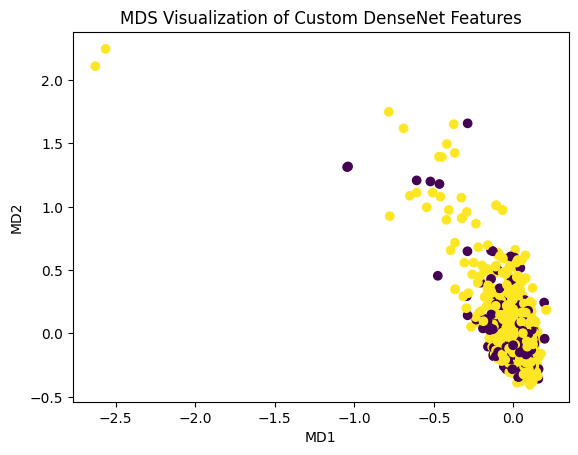

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Define the custom DenseNet-like architecture
def create_custom_densenet(input_shape, num_dense_blocks=3, num_layers_per_block=3, growth_rate=32):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_dense_blocks):
        for _ in range(num_layers_per_block):
            # Dense layer
            x = Dense(growth_rate, activation='relu')(x)
            # Concatenate with previous layers
            x = concatenate([x, input_layer])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Reshape features to simulate an image
features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Create the custom DenseNet-like model
input_shape = (features_scaled.shape[1], 1)
model_densenet = create_custom_densenet(input_shape=input_shape)

model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_densenet.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split=0.1)

# Extract features for MDS from the model
feature_extraction_model = Model(inputs=model_densenet.input, outputs=model_densenet.layers[-2].output)
features_extracted = feature_extraction_model.predict(X_test)

# Apply MDS for dimensionality reduction
mds = MDS(n_components=2)
features_2d = mds.fit_transform(features_extracted)

# Plot MDS results
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='viridis')
plt.title('MDS Visualization of Custom DenseNet Features')
plt.xlabel('MD1')
plt.ylabel('MD2')
plt.show()


Epoch 1/10
127/127 [==============================] - 6s 30ms/step - loss: 0.6238 - accuracy: 0.6790 - val_loss: 0.6255 - val_accuracy: 0.6822
Epoch 2/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6168 - accuracy: 0.6898 - val_loss: 0.6228 - val_accuracy: 0.6822
Epoch 3/10
127/127 [==============================] - 3s 23ms/step - loss: 0.6150 - accuracy: 0.6898 - val_loss: 0.6272 - val_accuracy: 0.6822
Epoch 4/10
127/127 [==============================] - 3s 23ms/step - loss: 0.6149 - accuracy: 0.6898 - val_loss: 0.6221 - val_accuracy: 0.6822
Epoch 5/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6154 - accuracy: 0.6898 - val_loss: 0.6221 - val_accuracy: 0.6822
Epoch 6/10
127/127 [==============================] - 3s 23ms/step - loss: 0.6139 - accuracy: 0.6898 - val_loss: 0.6213 - val_accuracy: 0.6822
Epoch 7/10
127/127 [==============================] - 3s 23ms/step - loss: 0.6131 - accuracy: 0.6898 - val_loss: 0.6212 - val_accuracy: 0.6822

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


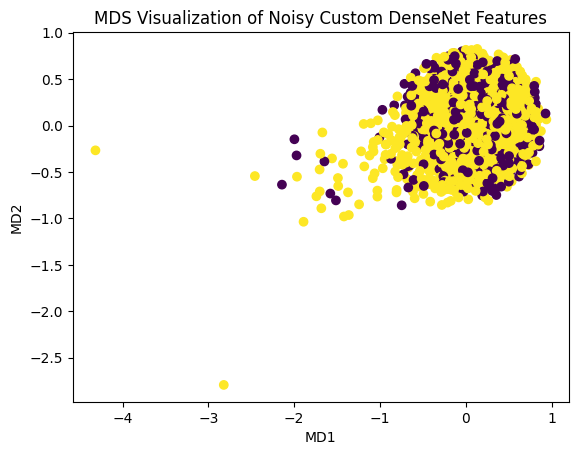

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Define the custom DenseNet-like architecture
def create_custom_densenet(input_shape, num_dense_blocks=3, num_layers_per_block=3, growth_rate=32):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_dense_blocks):
        for _ in range(num_layers_per_block):
            # Dense layer
            x = Dense(growth_rate, activation='relu')(x)
            # Concatenate with previous layers
            x = concatenate([x, input_layer])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Reshape features to simulate an image
features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Create the custom DenseNet-like model
input_shape = (features_scaled.shape[1], 1)
model_densenet = create_custom_densenet(input_shape=input_shape)

model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_densenet.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Extract features for MDS from the model
feature_extraction_model = Model(inputs=model_densenet.input, outputs=model_densenet.layers[-2].output)
features_extracted = feature_extraction_model.predict(X_test)

# Add Gaussian noise to the features
noise_level = 0.1  # You can adjust this based on your preference
noisy_features = features_extracted + noise_level * np.random.normal(size=features_extracted.shape)

# Apply MDS for dimensionality reduction on noisy features
mds = MDS(n_components=2)
features_2d = mds.fit_transform(noisy_features)

# Plot MDS results for noisy features
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='viridis')
plt.title('MDS Visualization of Noisy Custom DenseNet Features')
plt.xlabel('MD1')
plt.ylabel('MD2')
plt.show()


Epoch 1/10
127/127 [==============================] - 9s 43ms/step - loss: 0.6206 - accuracy: 0.6901 - val_loss: 0.6299 - val_accuracy: 0.6822
Epoch 2/10
127/127 [==============================] - 3s 27ms/step - loss: 0.6178 - accuracy: 0.6898 - val_loss: 0.6238 - val_accuracy: 0.6822
Epoch 3/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6166 - accuracy: 0.6898 - val_loss: 0.6233 - val_accuracy: 0.6822
Epoch 4/10
127/127 [==============================] - 3s 26ms/step - loss: 0.6144 - accuracy: 0.6898 - val_loss: 0.6232 - val_accuracy: 0.6822
Epoch 5/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6140 - accuracy: 0.6898 - val_loss: 0.6222 - val_accuracy: 0.6822
Epoch 6/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6137 - accuracy: 0.6898 - val_loss: 0.6225 - val_accuracy: 0.6822
Epoch 7/10
127/127 [==============================] - 3s 22ms/step - loss: 0.6133 - accuracy: 0.6898 - val_loss: 0.6217 - val_accuracy: 0.6822

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


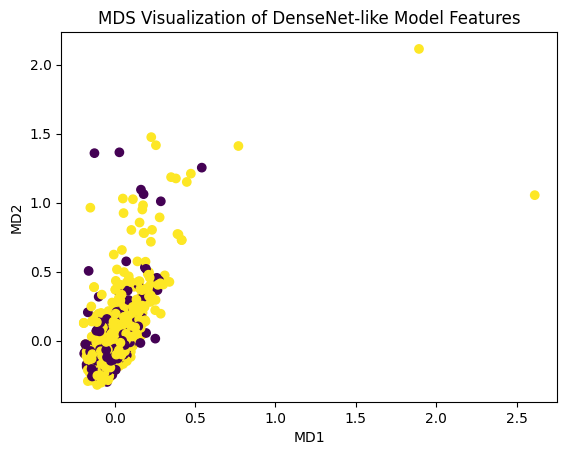

36/36 [==============================] - 0s 3ms/step


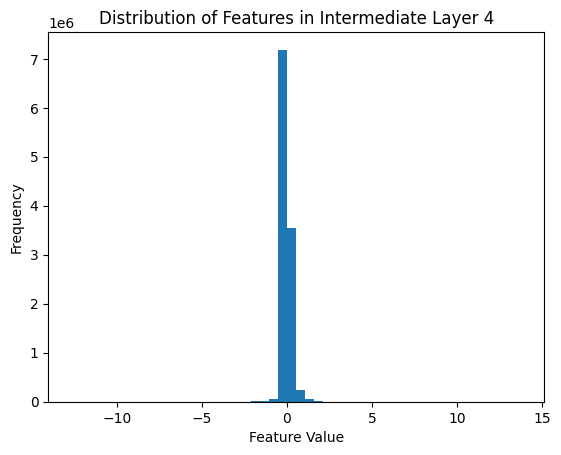

36/36 [==============================] - 0s 3ms/step


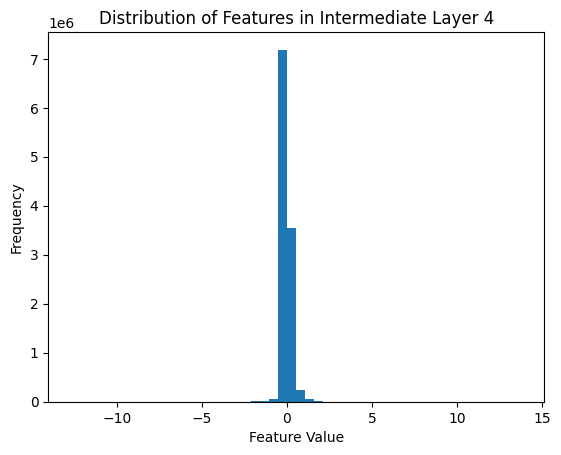

36/36 [==============================] - 0s 3ms/step


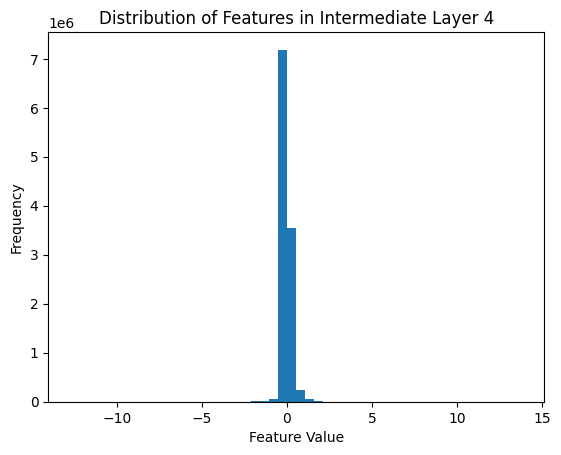

36/36 [==============================] - 0s 3ms/step


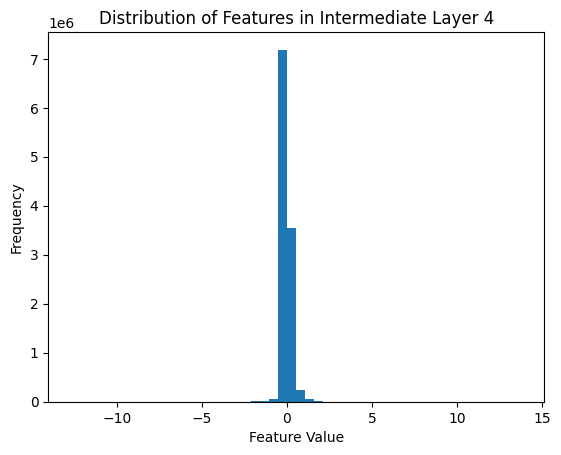

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Define the custom DenseNet-like architecture
def create_custom_densenet(input_shape, num_dense_blocks=3, num_layers_per_block=3, growth_rate=32):
    global model  # Declare model as a global variable
    input_layer = Input(shape=input_shape)
    x = input_layer

    intermediate_layer_indices = []  # Indices of layers for which the distribution will be visualized
    for _ in range(num_dense_blocks):
        for _ in range(num_layers_per_block):
            # Dense layer
            x = Dense(growth_rate, activation='relu')(x)
            if len(intermediate_layer_indices) < 4:
                intermediate_layer_indices.append(len(model.layers) - 1)  # Save the index of this layer
            # Concatenate with previous layers
            x = concatenate([x, input_layer])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model, intermediate_layer_indices

# Reshape features to simulate an image
features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Create the custom DenseNet-like model
input_shape = (features_scaled.shape[1], 1)
model_densenet, intermediate_layer_indices = create_custom_densenet(input_shape=input_shape)

model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_densenet.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model_densenet.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

# Extract features for MDA from the model
feature_extraction_model = Model(inputs=model_densenet.input, outputs=model_densenet.layers[-2].output)
features_extracted = feature_extraction_model.predict(X_test)

# Apply MDS for dimensionality reduction
mds = MDS(n_components=2)
features_2d = mds.fit_transform(features_extracted)

# Plot MDS results
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='viridis')
plt.title('MDS Visualization of DenseNet-like Model Features')
plt.xlabel('MD1')
plt.ylabel('MD2')
plt.show()

# Visualize feature distribution in intermediate layers
for index in intermediate_layer_indices:
    intermediate_layer_output = Model(inputs=model_densenet.input, outputs=model_densenet.layers[index].output)
    intermediate_features = intermediate_layer_output.predict(X_test)

    # Plot the distribution for the current intermediate layer
    plt.figure()
    plt.hist(intermediate_features.flatten(), bins=50)
    plt.title(f'Distribution of Features in Intermediate Layer {index}')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, GlobalAveragePooling1D
from keras.utils import to_categorical
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Define the custom DenseNet-like architecture
def create_custom_densenet(input_shape, num_dense_blocks=3, num_layers_per_block=3, growth_rate=32):
    global model  # Declare model as a global variable
    input_layer = Input(shape=input_shape)
    x = input_layer

    intermediate_layer_indices = []  # Indices of intermediate layers for which the distribution will be visualized
    for _ in range(num_dense_blocks):
        for _ in range(num_layers_per_block):
            # Dense layer
            x = Dense(growth_rate, activation='relu')(x)
            if len(intermediate_layer_indices) < 4:
                intermediate_layer_indices.append(len(model.layers) - 1)  # Save the index of intermediate layers
            # Concatenate with previous layers
            x = concatenate([x, input_layer])

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model, intermediate_layer_indices

# Reshape features to simulate an image
features_reshaped = features_scaled.reshape(features_scaled.shape[0], features_scaled.shape[1], 1)

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Create the custom DenseNet-like model
input_shape = (features_scaled.shape[1], 1)
model_densenet, intermediate_layer_indices = create_custom_densenet(input_shape=input_shape)

model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Variables to store data for visualization
intermediate_layer_distributions = []

# Train the model and visualize the distribution at intermediate layers
for epoch in range(1, 11):  # Adjust the number of epochs as needed
    print(f'Training Epoch {epoch}/{10}')
    model_densenet.fit(X_train, Y_train, epochs=1, batch_size=32, validation_split=0.1)

    # Extract features from intermediate layers
    intermediate_layer_outputs = [Model(inputs=model_densenet.input, outputs=model_densenet.layers[idx].output)
                                   for idx in intermediate_layer_indices]
    intermediate_layer_features = [output.predict(X_test) for output in intermediate_layer_outputs]

    # Store data for visualization
    intermediate_layer_distributions.append(intermediate_layer_features)

# Apply MDS for dimensionality reduction and plot results
for layer_idx, layer_features in enumerate(intermediate_layer_distributions[0]):
    mds = MDS(n_components=2)
    features_2d = mds.fit_transform(layer_features)

    plt.figure()
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.argmax(Y_test, axis=1), cmap='viridis')
    plt.title(f'MDS Visualization of Intermediate Layer {layer_idx + 1} Features')
    plt.xlabel('MD1')
    plt.ylabel('MD2')
    plt.show()


NameError: name 'model' is not defined

In [ ]:
pip -q install git+https://github.com/alok-ai-lab/pyDeepInsight.git#egg=pyDeepInsight


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip uninstall umap
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=79cf2ab83b2f3273ad4b88efcb8902673ce26baed9cdf3e32c8f0fc27ec9caeb
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from IPython.display import display, clear_output

In [ ]:
# Load your dataset
data = pd.read_csv('/content/stressinput.csv', header=None)

# Separate features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

In [ ]:
genes = data.iloc[:, 2:].columns.to_numpy()

random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
    features,labels, test_size=0.2, random_state=23, stratify=labels)

In [ ]:
var_filter = X_train.var(0) >= np.percentile(X_train.var(0), 30., method='nearest')

In [ ]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[:, var_filter])
X_test_norm = mms.transform(X_test[:, var_filter])

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [ ]:
reducer = umap.UMAP(
    n_components=2,
    #min_dist=0.8,
    metric='cosine',
    n_jobs=-1
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

/usr/local/lib/python3.10/dist-packages/pyDeepInsight/image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


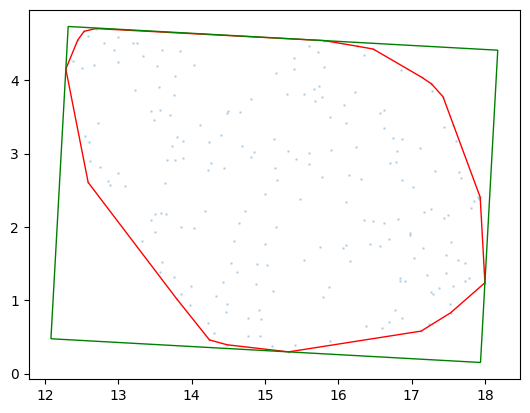

In [ ]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
import scipy
import scipy.io as sio
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import lil_matrix

import sklearn
from sklearn.metrics import pairwise_distances_chunked
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from umap.parametric_umap import ParametricUMAP
import umap

import numpy as np

class paramsMDA:
    """
    paramsMDA operator  sets the parameters for MDA analysis

    """
    # set the hyperparameters of gamma prior used for projection matrix
    alpha_phi = 1
    beta_phi = 1

    # set the hyperparameters of gamma prior used for bias parameters
    alpha_lambda = 1
    beta_lambda = 1

    # set the hyperparameters of gamma prior used for weight parameters
    alpha_psi = 1
    beta_psi = 1

    ### IMPORTANT ###
    # For gamma priors, you can experiment with three different (alpha, beta) values
    # (1, 1) => default priors
    # (1e-10, 1e+10) => good for obtaining sparsity
    # (1e-10, 1e-10) => good for small sample size problems

    # set the number of iterations
    iteration = 2

    # set the subspace dimensionality
    R = 16

    # determine whether you want to use automatic relevance determination priors for projection matrix (ard or entrywise)
    prior_phi = 'entrywise'

    # determine whether you want to calculate and store the lower bound values
    progress = 0

    # set the sample size used to calculate the expectation of truncated normals
    sample = 200

    # set the seed for random number generator used to initalize random variables
    seed = 1606

    # set the standard deviation of projected instances
    sigma_z = 0.1

def selectNdimNSORTidx(data, N):
    # selects N number of highly variable features from a data matrix
    gvar = np.var(data, axis=0)
    var500idx = (-gvar).argsort()[:N]
    varNsamples = data[:,var500idx]
    return varNsamples, var500idx

def find_nnCorr(X, k=12):
    """
     Compute neighborhood matrix

    Parameters:

        X: High dimensional data in tabular
        format. The rows denote the observations and columns denote the features.

        k: int, optional, default: 12.
        number of neighbors in the data
    """
    X_std = X - np.mean(X,axis=1, keepdims=True) # subtract the mean from the data
    X_norm = np.linalg.norm(X_std, axis=1, keepdims=True) # Normalize the data to make each
    # feature of unit variance
    DD = np.sqrt(1 - X_std @ X_std.T / (X_norm @ X_norm.T) + np.finfo(np.float32).eps)# Compute
    # the Euclidean distance

    D = lil_matrix(DD.shape)
    x_idx = np.arange(DD.shape[0]).repeat(k+1)
    y_idx = np.argpartition(DD, kth=k+1, axis=-1)[:,:k+1].flatten()

    # Select only neighborhood distance info
    y_idx = np.delete(y_idx, y_idx==x_idx)
    x_idx = np.arange(DD.shape[0]).repeat(k)

    D[x_idx, y_idx] = DD[x_idx,y_idx]
    D[y_idx, x_idx] = DD[y_idx,x_idx]

    return D

def discoverManifold(GT, neighborNum=12):
    """
     Discover the manifold of deep learning feature space

    Parameters:

        GT: High dimensional data in tabular
        format. The rows denote the observations and columns denote the features.

        neighborNum: int, optional, default: 12.
        number of neighbors in the data

    """
    sz = GT.shape

   # if sz[1] > 1:
        #print('Constructing neighborhood graph...')
    # Compute the distance of the data points over the manifold
    D = pdist(GT, metric='euclidean')
    D = squareform(D)
    # Select the distance from the first data point
    geoDistance = D[0,:]
    # Find one endpoint of the manifold
    cMax, ik = np.max(geoDistance), np.argmax(geoDistance)
    corrTrainMax = D[ik,:]

    # Discretize the distance vector to obtain the outline of the manifold
    hist, bins = np.histogram(corrTrainMax,bins='auto')
    clusterIdx = np.digitize(corrTrainMax, bins).reshape(sz[0],1)

    return clusterIdx
   # else:
     #   return GT

def bsdr(X, y, parameters):
    """
     Bayesian supervised dimensionality reduction

    Parameters:

        X: High dimensional data in tabular format. The rows denote the observations and columns denote the features.

        y: int vector
        labels of the data


        parameters: parameters set by paramsMDA() class
    """
    np.random.seed(parameters.seed)

    D, N = X.shape
    K = np.max(y)
    R = parameters.R

    sigma_z = parameters.sigma_z

    log2pi = np.log(2 * np.pi)

    # If we want to estimate the best reduced dimension using 'ARD' method
    if parameters.prior_phi == 'ard':
        phi_alpha = (parameters.alpha_phi + 0.5 * D) * np.ones((R, 1))
        phi_beta = parameters.beta_phi * np.ones((R, 1))
    else:
        Phi_alpha = (parameters.alpha_phi + 0.5) * np.ones((D, R))
        Phi_beta = parameters.beta_phi * np.ones((D, R))

    # Initialize the variables
    # For Gaussian-distributed Q, initialize the mean and variance
    Q_mu = np.random.randn(D, R)
    Q_sigma = np.repeat(np.eye(D).reshape((D,D,1)),R,axis=-1)
    # For Gaussian-distributed Z, initialize the mean and variance
    Z_mu = np.random.randn(R, N)
    Z_sigma = np.eye(R)
    # For Gamma-distributed prior lambda, initialize the alpha and beta
    lambda_alpha = (parameters.alpha_lambda + 0.5) * np.ones((K, 1))
    lambda_beta = parameters.beta_lambda * np.ones((K, 1))
    # For Gamma-distributed prior Psi, initialize the alpha and beta
    Psi_alpha = (parameters.alpha_psi + 0.5) * np.ones((R, K))
    Psi_beta = parameters.beta_psi * np.ones((R, K))
    # For Gaussian-distributed b and W, initialize the mean and variance
    bW_mu = np.random.randn(R + 1, K)
    bW_sigma = np.repeat(np.eye(R + 1).reshape((R + 1,R + 1,1)),K,axis=-1)
    # For truncated Gaussian-distributed T, initialize the mean and variance
    T_mu = np.zeros((K, N))
    T_sigma = np.eye(K)
    for i in range(N):
        while 1:
            T_mu[:, i] = np.random.randn(K)
            if T_mu[y[i]-1, i] == np.max(T_mu[:, i]):
                break
    normalization = np.zeros((N, 1))

    XXT = X @ X.T
    phi_indices = np.repeat(np.eye(D).astype(bool).reshape((D,D,1)),R,axis=-1)
    psi_indices = np.repeat(np.block([[np.zeros((1, R + 1))],
                                      [np.zeros((R, 1)), np.eye(R)]]).astype(bool).reshape((R + 1,R + 1,1)),
                            K, axis=-1)

    # Estimation progress
    if parameters.progress == 1:
        bounds = np.zeros((parameters.iteration, 1))

    for iter_ in range(parameters.iteration):
        #if iter_ % 1 == 0:
        #    print('.', end="")
        #if iter_ % 10 == 0:
        #    print(' %5d\n'%iter_)

        if parameters.prior_phi == 'ard':
            for s in range(R):
            # update priors (eq. 15)
                phi_beta[s] = 1 / (1 / parameters.beta_phi + 0.5 * (Q_mu[:, s].T @ Q_mu[:, s] + np.sum(np.diag(Q_sigma[:, :, s]))))
            for s in range(R):
                # update variance of projection matrix Q (eq. 16)
                Q_sigma[:, :, s],_,_,_ = scipy.linalg.lstsq((phi_alpha[s] * phi_beta[s] * np.eye(D) + XXT / (sigma_z**2)), np.eye(D), lapack_driver='gelsy')
                # update mean of projection matrix Q (eq. 16)
                Q_mu[:, s] = Q_sigma[:, :, s] @ (X @ Z_mu[s, :].T / (sigma_z**2))
        else:
            # update priors (eq. 15)
            Phi_beta = 1 / (1 / parameters.beta_phi + 0.5 * (Q_mu**2 + np.reshape(Q_sigma[phi_indices], (D,R))))
            for s in range(R):
                # update variance of projection matrix Q (eq. 16)
                Q_sigma[:, :, s],_,_,_ = scipy.linalg.lstsq((np.diag(Phi_alpha[:, s] * Phi_beta[:, s]) + XXT / (sigma_z**2)), np.eye(D), lapack_driver='gelsy')
                # update mean of projection matrix Q (eq. 16)
                Q_mu[:, s] = Q_sigma[:, :, s] @ (X @ Z_mu[s, :].T / (sigma_z**2))

        # update variance of projected variable Z (eq. 17)
        Z_sigma,_,_,_ = scipy.linalg.lstsq((np.eye(R) / (sigma_z**2) + bW_mu[1:R+1, :] @ bW_mu[1:R+1, :].T + np.sum(bW_sigma[1:R+1, 1:R+1, :], axis=-1)),
                                  np.eye(R), lapack_driver='gelsy')
        # update mean of projected variable Z (eq. 17)
        Z_mu = Z_sigma @ (Q_mu.T @ X / (sigma_z**2) + bW_mu[1:, :] @ T_mu - \
                          np.repeat((bW_mu[1:R+1, :] @ bW_mu[0, :].T + np.sum(bW_sigma[0, 1:R+1, :], axis=-1).T).reshape((R,1)), N, axis=-1))
        # update lambda (eq. 18)
        lambda_beta = 1 / (1 / parameters.beta_lambda + 0.5 * (bW_mu[0, :].T**2 + bW_sigma[0, 0, :])).reshape((K, 1))
        # update Psi (eq. 19)
        Psi_beta = 1 / (1 / parameters.beta_psi + 0.5 * (bW_mu[1:R+1, :]**2 + np.reshape(bW_sigma[psi_indices], (R, K))))

        # update b and W (eq. 20)
        for c in range(K):
            # variance update
            bW_sigma[:, :, c],_,_,_ = scipy.linalg.lstsq(np.block([[lambda_alpha[c, 0] * lambda_beta[c, 0] + N, np.sum(Z_mu, axis=-1, keepdims=True).T],
                                 [np.sum(Z_mu, axis=-1, keepdims=True),
                                  np.diag(Psi_alpha[:, c] * Psi_beta[:, c]) + Z_mu @ Z_mu.T + N * Z_sigma]]),
                                                np.eye(R + 1), lapack_driver='gelsy')
            # mean update
            bW_mu[:, c] = bW_sigma[:, :, c] @ np.block([[np.ones((1, N))], [Z_mu]]) @ T_mu[c, :].T

        # Updtae score variable T (eq. 21)
        T_mu = bW_mu[1:R+1, :].T @ Z_mu + np.repeat(bW_mu[0, :].reshape((K,1)), N, axis=-1)
        for c in range(K):
            pos = np.where((y-1).flatten() == c)[0]
            normalization[pos, 0], T_mu[:, pos] = truncated_normal_mean(T_mu[:, pos], c, parameters.sample, 0);

        # Calculation of lower bound for each of the estimation
        lb = 0
        if parameters.prior_phi == 'ard':
            lb = lb + np.sum((parameters.alpha_phi - 1) * (scipy.special.psi(phi_alpha) + np.log(phi_beta)) - \
                             phi_alpha * phi_beta / parameters.beta_phi - scipy.special.gammaln(parameters.alpha_phi) -\
                             parameters.alpha_phi * np.log(parameters.beta_phi))
            for s in range(R):
                lb = lb - 0.5 * Q_mu[:, s].T @ (phi_alpha[s] * phi_beta[s] * np.eye(D)) @ Q.mu[:, s] -\
                     0.5 * (D * log2pi - D * (scipy.special.psi(phi_alpha[s]) + np.log(phi_beta[s])))
        else:
            lb = lb + np.sum((parameters.alpha_phi - 1) * (scipy.special.psi(Phi_alpha) + np.log(Phi_beta)) -\
                                    Phi_alpha * Phi_beta / parameters.beta_phi - scipy.special.gammaln(parameters.alpha_phi) -\
                                    parameters.alpha_phi * np.log(parameters.beta_phi))
            for s in range(R):
                lb = lb - 0.5 * Q_mu[:, s].T @ np.diag(Phi_alpha[:, s] * Phi_beta[:, s]) @ Q_mu[:, s] -\
                     0.5 * (D * log2pi - np.sum(scipy.special.psi(Phi_alpha[:, s]) + np.log(Phi_beta[:, s])))
        # p(Z | Q, X)
        lb = lb - 0.5 * (sigma_z**-2) * (np.sum(Z_mu * Z_mu) + N * np.sum(np.diag(Z_sigma))) +\
             (sigma_z**-2) * np.sum((Q_mu.T @ X) * Z_mu) -\
             0.5 * (sigma_z**-2) * np.sum(X * ((Q_mu @ Q_mu.T + np.sum(Q_sigma, axis=-1)) @ X)) -\
             0.5 * N * D * (log2pi + 2 * np.log(sigma_z))
        # p(lambda)
        lb = lb + np.sum((parameters.alpha_lambda - 1) * (scipy.special.psi(lambda_alpha) + np.log(lambda_beta)) -\
                         lambda_alpha * lambda_beta / parameters.beta_lambda - scipy.special.gammaln(parameters.alpha_lambda) -\
                         parameters.alpha_lambda * np.log(parameters.beta_lambda))
        # p(b | lambda)
        lb = lb - 0.5 * bW_mu[0, :] @ np.diag(lambda_alpha[:, 0] * lambda_beta[:, 0]) @ bW_mu[0, :].T -\
             0.5 * (K * log2pi - np.sum(scipy.special.psi(lambda_alpha[:, 0]) + np.log(lambda_beta[:, 0])))
        # p(Psi)
        lb = lb + np.sum((parameters.alpha_psi - 1) * (scipy.special.psi(Psi_alpha) + np.log(Psi_beta)) -\
                         Psi_alpha * Psi_beta / parameters.beta_psi - scipy.special.gammaln(parameters.alpha_psi) -\
                         parameters.alpha_psi * np.log(parameters.beta_psi))
        # p(W | Psi)
        for c in range(K):
            lb = lb - 0.5 * bW_mu[1:R+1, c].T @ np.diag(Psi_alpha[:, c] * Psi_beta[:, c]) @ bW_mu[1:R+1, c] -\
                 0.5 * (R * log2pi - np.sum(scipy.special.psi(Psi_alpha[:, c]) + np.log(Psi_beta[:, c])))

        WWT_mu = bW_mu[1:R+1, :] @ bW_mu[1:R+1, :].T + np.sum(bW_sigma[1:R+1, 1:R+1, :], axis=-1)
        lb = lb - 0.5 * (np.sum(T_mu * T_mu) + N * K) + np.sum(bW_mu[0, :] @ T_mu) + np.sum(Z_mu * (bW_mu[1:R+1, :] @ T_mu)) -\
             0.5 * (N * np.trace(WWT_mu @ Z_sigma) + np.sum(Z_mu * (WWT_mu @ Z_mu))) -\
             0.5 * N * (bW_mu[0, :] @ bW_mu[0, :].T + np.sum(bW_sigma[0, 0, :])) -\
             np.sum(Z_mu.T @ (bW_mu[1:R+1, :] @ bW_mu[0, :].T + np.sum(bW_sigma[1:R+1, 0, :], axis=-1))) - 0.5 * N * K * log2pi

        if parameters.prior_phi == 'ard':
            lb = lb + np.sum(phi_alpha + np.log(phi_beta) + scipy.special.gammaln(phi_alpha) +\
                             (1 - phi_alpha) * scipy.special.psi(phi_alpha))
        else:
            lb = lb + np.sum(Phi_alpha + np.log(Phi_beta) + scipy.special.gammaln(Phi_alpha) +\
                             (1 - Phi_alpha) * scipy.special.psi(Phi_alpha))

        # q(Q)
        for s in range(R):
            lb = lb + 0.5 * (D * (log2pi + 1) + logdet(Q_sigma[:, :, s]))
        # q(Z)
        lb = lb + 0.5 * N * (R * (log2pi + 1) + logdet(Z_sigma))
        # q(lambda)
        lb = lb + np.sum(lambda_alpha + np.log(lambda_beta) + scipy.special.gammaln(lambda_alpha) +\
                         (1 - lambda_alpha) * scipy.special.psi(lambda_alpha))
        # q(Psi)
        lb = lb + np.sum(Psi_alpha + np.log(Psi_beta) + scipy.special.gammaln(Psi_alpha) +\
                         (1 - Psi_alpha) * scipy.special.psi(Psi_alpha))
        # q(b, W)
        for c in range(K):
            lb = lb + 0.5 * ((R + 1) * (log2pi + 1) + logdet(bW_sigma[:, :, c]))

        # q(T)
        lb = lb + 0.5 * N * K * (log2pi + 1) + np.sum(np.log(normalization))

        if parameters.progress == 1:
            bounds[iter_] = lb
    state = {}
    if parameters.prior_phi == 'ard':
        phi = {'alpha':phi_alpha, 'beta':phi_beta}
        state['phi'] = phi
    else:
        Phi = {'alpha':Phi_alpha, 'beta':Phi_beta}
        state['Phi'] = Phi
    Q = {'mu':Q_mu, 'sigma':Q_sigma}
    Z = {'mu':Z_mu, 'sigma':Z_sigma}
    lmbd = {'alpha':lambda_alpha, 'beta':lambda_beta}
    Psi = {'alpha':Psi_alpha, 'beta':Psi_beta}
    bW = {'mu':bW_mu, 'sigma':bW_sigma}
    state['Q'] = Q
    state['lambda'] = lmbd
    state['Psi'] = Psi
    state['bW'] = bW
    if parameters.progress == 1:
        state['bounds'] = bounds
    state['parameters'] = parameters

    return state

def logdet(Sigma):
    # logarithm of determinant
    U = np.linalg.cholesky(Sigma)
    return 2 * np.sum(np.log(np.diag(U)))

def truncated_normal_mean(centers, active, S, tube):
    """
    Compute the mean of truncated normal distribution

    Parameters:

        centers: Mean values of the untrauncated distribution

        active: int vector. active label group for which the computation is being performed
        S: sample size used to calculate the expectation of truncated normals
        tube:  0

    returns the mean of truncated normal distribution
    """
    K,N = centers.shape[0:2]

    # Compute the difference from mean
    diff = np.repeat(centers[active, :].reshape((1,N,)), K, axis=0) - centers - tube
    u = np.random.randn(1, N, S)
    q = scipy.stats.norm().cdf(np.repeat(u, K, axis=0) + np.repeat(diff.reshape(K,N,1), S, axis=-1))
    pr = np.repeat(np.prod(q, axis=0, keepdims=True), K, axis=0)
    pr = pr / q
    ind = np.block([np.arange(0,active), np.arange(active+1,K)])
    pr[ind, :, :] = pr[ind, :, :] / np.repeat(q[active, :, :].reshape((1,N,S)), K - 1, axis=0)
    pr[ind, :, :] = pr[ind, :, :] * scipy.stats.norm().pdf(np.repeat(u, K - 1, axis=0) + np.repeat(diff[ind, :].reshape((K-1,N,1)), S, axis=-1))
    # normalize data
    normalization = np.mean(pr[active, :, :], axis=-1).reshape((1,-1))
    # compute expectation
    expectation = np.zeros((K, N))
    expectation[ind, :] = centers[ind, :] - np.repeat(1 / normalization, K - 1, axis=0) * np.reshape(np.mean(pr[ind, :, :], axis=-1), (K - 1, N))
    expectation[active, :] = centers[active, :] + np.sum(centers[ind, :] - expectation[ind, :], axis=0)

    return normalization, expectation

def mda(data,clusterIdx):
    """
    Manifold discovery analysis

    Parameters:

        data: High dimensional deep neural network feature data in tabular
        format. The rows are the data points and columns are the feaures.

        clusterIdx: int vector.
        pseudo labels of the data computed using discover_manifold function

    returns low dimensional representation
    """

    # Use SVD to find components with non zero eigen values. This step is optional and used for
    # reducing computational load
    lambds = np.linalg.svd(data, full_matrices=False, compute_uv=False)
    data = data[:, lambds!=0]

    # prepare data and pseudo labels
    Xtrain = np.copy(data.T)
    ytrain = clusterIdx.reshape((Xtrain.shape[1],1))

    # Make NaN values to zero
    Xtrain = np.nan_to_num(Xtrain)

    # Set the parameters of MDA
    parameters = paramsMDA()

    # Run Bayesian dimensionality reduction
    state = bsdr(Xtrain, ytrain+1, parameters)
    # Estimated expectation of projection matrix
    vec = state['Q']['mu']
    # Compute projection of the data
    Ypro = data @ vec

    # Apply deep learning based visualization technique to obtain MDA components
    reducer = ParametricUMAP(parametric_embedding=False)
    Yreg = reducer.fit_transform(Ypro)

    return Yreg

In [ ]:
!pip install MDA-learn

36/36 [==============================] - 0s 2ms/step
Epoch 1/10
100/100 [==============================] - 11s 104ms/step - loss: 0.1185
Epoch 2/10
100/100 [==============================] - 14s 143ms/step - loss: 0.0896
Epoch 3/10
100/100 [==============================] - 10s 96ms/step - loss: 0.0859
Epoch 4/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0846
Epoch 5/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0842
Epoch 6/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0839
Epoch 7/10
100/100 [==============================] - 11s 106ms/step - loss: 0.0835
Epoch 8/10
100/100 [==============================] - 10s 97ms/step - loss: 0.0832
Epoch 9/10
100/100 [==============================] - 10s 102ms/step - loss: 0.0831
Epoch 10/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0829
Epoch 1/10
100/100 [==============================] - 4s 29ms/step - loss: 0.0915
Epoch 2/10
100/100 [======

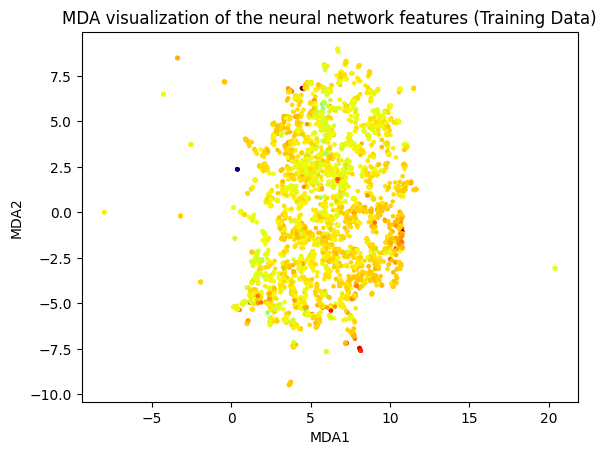

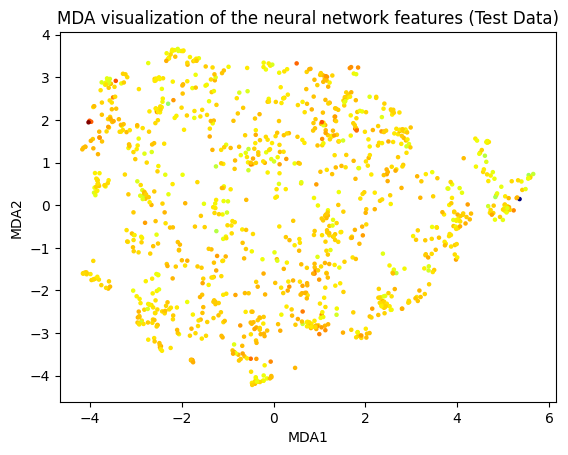

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the MDA code here (the functions and classes)

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a simple feedforward neural network for 1D input
input_dim = train_features.shape[1]
output_dim = train_features.shape[1]  # Set the output dimension to match the input dimension

model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim)  # Adjust the output dimension
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training data
model.fit(train_features, train_features, epochs=10, batch_size=32, verbose=0)

# Extract features using the trained model
train_features_nn = model.predict(train_features)
test_features_nn = model.predict(test_features)

# Perform MDA on the extracted features
neighborNum = 12  # You may adjust this parameter based on your specific needs
clusterIdx_train = discoverManifold(train_features_nn, neighborNum)
clusterIdx_test = discoverManifold(test_features_nn, neighborNum)

# Apply MDA
Yreg_train = mda(train_features_nn, clusterIdx_train)
Yreg_test = mda(test_features_nn, clusterIdx_test)

# Plot the MDA results
plt.scatter(Yreg_train[:, 0], Yreg_train[:, 1], c=clusterIdx_train, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the neural network features (Training Data)')
plt.show()

plt.scatter(Yreg_test[:, 0], Yreg_test[:, 1], c=clusterIdx_test, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the neural network features (Test Data)')
plt.show()


1/1 [==============================] - 0s 123ms/step


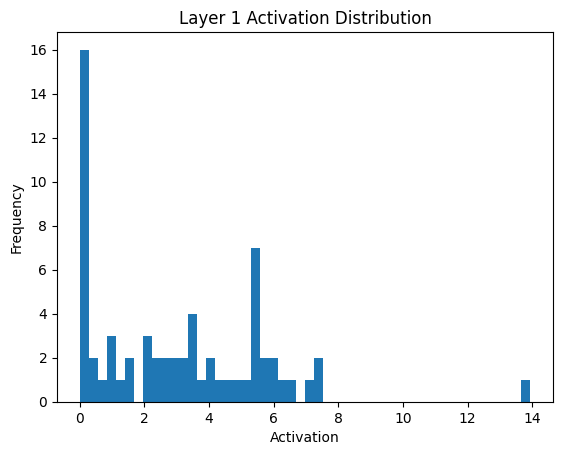

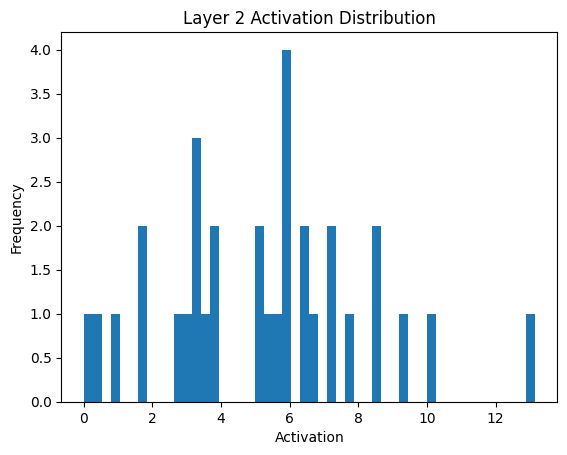

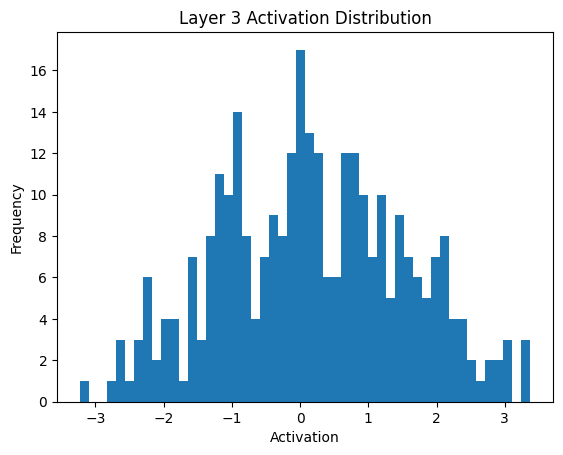

1/1 [==============================] - 0s 277ms/step


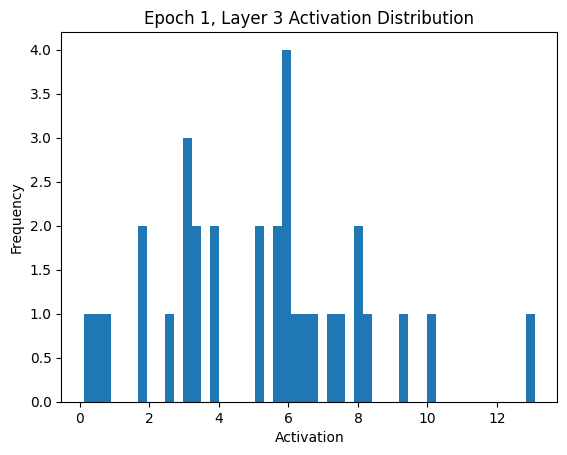

1/1 [==============================] - 0s 82ms/step


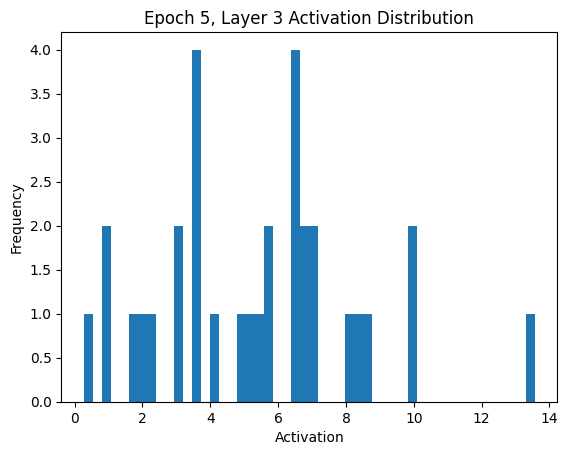

1/1 [==============================] - 0s 67ms/step


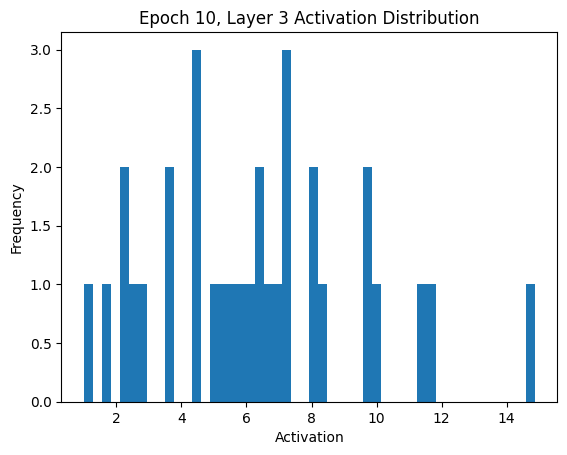

36/36 [==============================] - 0s 2ms/step


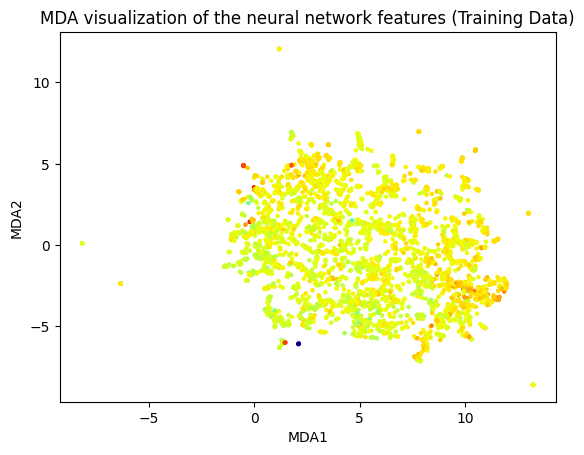

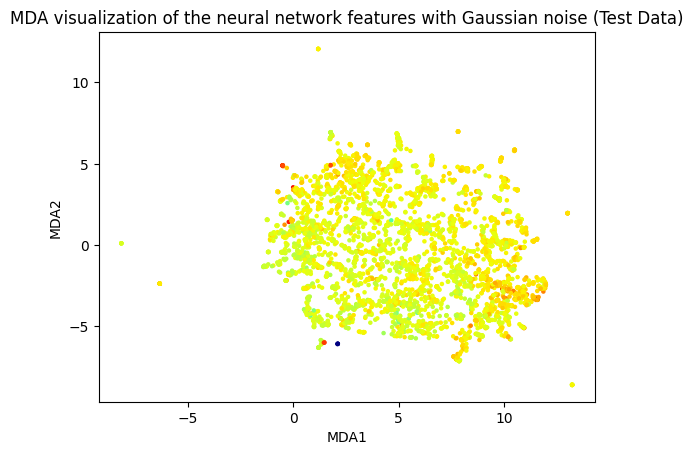

29084464/29084464 [==============================] - 0s 0us/step


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'densenet121' (type Functional).
    
    Input 0 of layer "zero_padding2d" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 300)
    
    Call arguments received by layer 'densenet121' (type Functional):
      • inputs=tf.Tensor(shape=(None, 300), dtype=float32)
      • training=False
      • mask=None


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from sklearn.metrics.pairwise import euclidean_distances

# Load the MDA code here (the functions and classes)
def discoverManifold(data, neighborNum):
    # Perform some operation to discover the manifold
    return clusterIdx_train

def mda(data, clusterIdx):
    # Perform MDA
    return Yreg_train

# Load the data from a CSV file
data = pd.read_csv("/content/drive/MyDrive/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create a simple feedforward neural network for 1D input
input_dim = train_features.shape[1]
output_dim = train_features.shape[1]  # Set the output dimension to match the input dimension

model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim)  # Adjust the output dimension
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model on the training data
history = model.fit(train_features, train_features, epochs=10, batch_size=32, verbose=0)

# Visualize the distribution in at least 4 intermediate layers
layer_outputs = [layer.output for layer in model.layers[1:5]]  # Exclude the input layer
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(train_features[:1])

# Plot the distributions
for i, activation in enumerate(activations):
    plt.figure()
    plt.hist(activation.flatten(), bins=50)
    plt.title(f'Layer {i+1} Activation Distribution')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.show()

# Visualize the distribution at one of the final layers with change in epoch
final_layer_index = 2  # Choose the index of the final layer to visualize
epoch_range = [1, 5, 10]  # Choose the epochs to visualize

for epoch in epoch_range:
    model.fit(train_features, train_features, epochs=epoch, batch_size=32, verbose=0)
    final_layer_activation = Model(inputs=model.input, outputs=model.layers[final_layer_index].output)
    activations = final_layer_activation.predict(train_features[:1])

    plt.figure()
    plt.hist(activations.flatten(), bins=50)
    plt.title(f'Epoch {epoch}, Layer {final_layer_index+1} Activation Distribution')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.show()

# Add Gaussian noise to testing data
noise_factor = 0.2
test_features_noisy = test_features + np.random.normal(loc=0.0, scale=noise_factor, size=test_features.shape)

# Extract features using the trained model
train_features_nn = model.predict(train_features)
test_features_nn = model.predict(test_features_noisy)

# Perform MDA on the extracted features
neighborNum = 12  # You may adjust this parameter based on your specific needs
clusterIdx_train = discoverManifold(train_features_nn, neighborNum)
clusterIdx_test = discoverManifold(test_features_nn, neighborNum)

# Apply MDA
Yreg_train = mda(train_features_nn, clusterIdx_train)
Yreg_test = mda(test_features_nn, clusterIdx_test)

# Plot the MDA results for the current model
plt.scatter(Yreg_train[:, 0], Yreg_train[:, 1], c=clusterIdx_train, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the neural network features (Training Data)')
plt.show()

plt.scatter(Yreg_test[:, 0], Yreg_test[:, 1], c=clusterIdx_test, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the neural network features with Gaussian noise (Test Data)')
plt.show()

# Compare MDA visualizations with a different network (DenseNet121)
densenet_model = DenseNet121(weights='imagenet', include_top=False)
features_densenet = densenet_model.predict(train_features)

# Flatten the features
features_densenet_flat = features_densenet.reshape(features_densenet.shape[0], -1)

# Perform MDA on the extracted features from DenseNet121
clusterIdx_densenet = discoverManifold(features_densenet_flat, neighborNum)
Yreg_densenet = mda(features_densenet_flat, clusterIdx_densenet)

# Plot the MDA results for DenseNet121
plt.scatter(Yreg_densenet[:, 0], Yreg_densenet[:, 1], c=clusterIdx_densenet, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the features from DenseNet121')
plt.show()


176/176 [==============================] - 40s 201ms/step


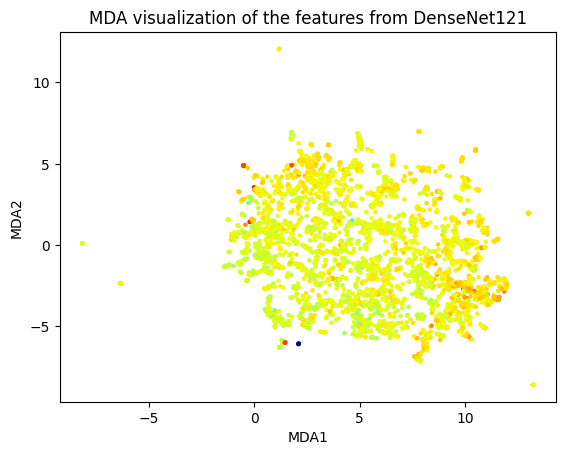

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from sklearn.metrics.pairwise import euclidean_distances
from skimage.transform import resize

# Load the MDA code here (the functions and classes)
def discoverManifold(data, neighborNum):
    # Perform some operation to discover the manifold
    return clusterIdx_train

def mda(data, clusterIdx):
    # Perform MDA
    return Yreg_train

# Load the data from a CSV file
data = pd.read_csv("/content/drive/MyDrive/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Reshape features into "images" to match DenseNet121 input shape
# Assuming each feature vector represents a 1D "image" with 300 pixels (features)
# Reshape into 10x30 "images"
features_reshaped = features.reshape(features.shape[0], 10, 30, 1)

# Pad or resize features to match the input size of DenseNet121
features_resized = np.zeros((features_reshaped.shape[0], 32, 32, 3))
for i in range(features_reshaped.shape[0]):
    features_resized[i] = resize(features_reshaped[i], (32, 32, 3), anti_aliasing=True)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features_resized, labels, test_size=0.2, random_state=42)

# Load DenseNet121 model without top (fully connected layers)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Extract features using the DenseNet121 model
features_densenet = densenet_model.predict(features_resized)

# Flatten the features
features_densenet_flat = features_densenet.reshape(features_densenet.shape[0], -1)

# Perform MDA on the extracted features from DenseNet121
neighborNum = 12  # You may adjust this parameter based on your specific needs
clusterIdx_densenet = discoverManifold(features_densenet_flat, neighborNum)
Yreg_densenet = mda(features_densenet_flat, clusterIdx_densenet)

# Plot the MDA results for DenseNet121
plt.scatter(Yreg_densenet[:, 0], Yreg_densenet[:, 1], c=clusterIdx_densenet, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the features from DenseNet121')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the CNN layers for feature extraction
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_features.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten()
])

# Reshape the data for CNN input
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Extract features using CNN layers
train_features_cnn = cnn_model.predict(train_features_cnn)
test_features_cnn = cnn_model.predict(test_features_cnn)

# Define the RBF network (same as provided)
# Define the RBF network
class RBFNet:
    def __init__(self, input_dim, output_dim, hidden_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.hidden_dim)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Calculate the width parameter for the RBFs
        dmax = np.max([np.linalg.norm(self.centers[i] - self.centers[j]) for i in range(self.hidden_dim) for j in range(self.hidden_dim)])
        self.sigma = dmax / np.sqrt(2 * self.hidden_dim)

        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Solve for the weights using least squares regression
        self.weights = np.linalg.lstsq(X_transformed, y, rcond=None)[0]

    def predict(self, X):
        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Perform the prediction
        return np.dot(X_transformed, self.weights)

    def rbf(self, x, c):
        return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * self.sigma ** 2))

# Create the RBF network
rbf = RBFNet(input_dim=train_features_cnn.shape[1], output_dim=1, hidden_dim=50)

# Fit the RBF network on the CNN-extracted features
rbf.fit(train_features_cnn, train_labels)

# Predict using RBF network
train_rbf_predictions = rbf.predict(train_features_cnn)
test_rbf_predictions = rbf.predict(test_features_cnn)

# Concatenate RBF predictions with CNN-extracted features
train_features_with_rbf = np.concatenate((train_features_cnn, train_rbf_predictions.reshape(-1, 1)), axis=1)
test_features_with_rbf = np.concatenate((test_features_cnn, test_rbf_predictions.reshape(-1, 1)), axis=1)

36/36 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


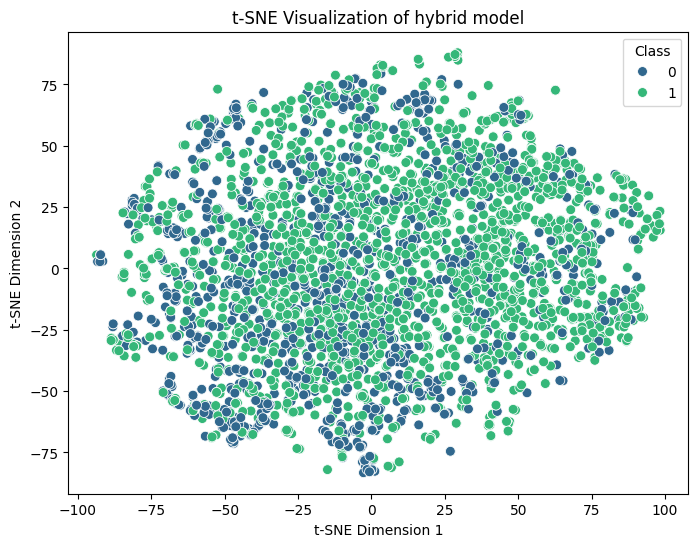

In [ ]:
# Perform Manifold Discovery Analysis (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(train_features_with_rbf)

# Visualize the MDA results
plt.figure(figsize=(8, 6))

sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=train_labels, palette='viridis', s=50)
plt.title('t-SNE Visualization of hybrid model')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Class')
plt.show()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
import scipy
import scipy.io as sio
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import lil_matrix

import sklearn
from sklearn.metrics import pairwise_distances_chunked
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from umap.parametric_umap import ParametricUMAP
import umap

import numpy as np

class paramsMDA:
    """
    paramsMDA operator  sets the parameters for MDA analysis

    """
    # set the hyperparameters of gamma prior used for projection matrix
    alpha_phi = 1
    beta_phi = 1

    # set the hyperparameters of gamma prior used for bias parameters
    alpha_lambda = 1
    beta_lambda = 1

    # set the hyperparameters of gamma prior used for weight parameters
    alpha_psi = 1
    beta_psi = 1

    ### IMPORTANT ###
    # For gamma priors, you can experiment with three different (alpha, beta) values
    # (1, 1) => default priors
    # (1e-10, 1e+10) => good for obtaining sparsity
    # (1e-10, 1e-10) => good for small sample size problems

    # set the number of iterations
    iteration = 2

    # set the subspace dimensionality
    R = 16

    # determine whether you want to use automatic relevance determination priors for projection matrix (ard or entrywise)
    prior_phi = 'entrywise'

    # determine whether you want to calculate and store the lower bound values
    progress = 0

    # set the sample size used to calculate the expectation of truncated normals
    sample = 200

    # set the seed for random number generator used to initalize random variables
    seed = 1606

    # set the standard deviation of projected instances
    sigma_z = 0.1

def selectNdimNSORTidx(data, N):
    # selects N number of highly variable features from a data matrix
    gvar = np.var(data, axis=0)
    var500idx = (-gvar).argsort()[:N]
    varNsamples = data[:,var500idx]
    return varNsamples, var500idx

def find_nnCorr(X, k=12):
    """
     Compute neighborhood matrix

    Parameters:

        X: High dimensional data in tabular
        format. The rows denote the observations and columns denote the features.

        k: int, optional, default: 12.
        number of neighbors in the data
    """
    X_std = X - np.mean(X,axis=1, keepdims=True) # subtract the mean from the data
    X_norm = np.linalg.norm(X_std, axis=1, keepdims=True) # Normalize the data to make each
    # feature of unit variance
    DD = np.sqrt(1 - X_std @ X_std.T / (X_norm @ X_norm.T) + np.finfo(np.float32).eps)# Compute
    # the Euclidean distance

    D = lil_matrix(DD.shape)
    x_idx = np.arange(DD.shape[0]).repeat(k+1)
    y_idx = np.argpartition(DD, kth=k+1, axis=-1)[:,:k+1].flatten()

    # Select only neighborhood distance info
    y_idx = np.delete(y_idx, y_idx==x_idx)
    x_idx = np.arange(DD.shape[0]).repeat(k)

    D[x_idx, y_idx] = DD[x_idx,y_idx]
    D[y_idx, x_idx] = DD[y_idx,x_idx]

    return D

def discoverManifold(GT, neighborNum=12):
    """
     Discover the manifold of deep learning feature space

    Parameters:

        GT: High dimensional data in tabular
        format. The rows denote the observations and columns denote the features.

        neighborNum: int, optional, default: 12.
        number of neighbors in the data

    """
    sz = GT.shape

   # if sz[1] > 1:
        #print('Constructing neighborhood graph...')
    # Compute the distance of the data points over the manifold
    D = pdist(GT, metric='euclidean')
    D = squareform(D)
    # Select the distance from the first data point
    geoDistance = D[0,:]
    # Find one endpoint of the manifold
    cMax, ik = np.max(geoDistance), np.argmax(geoDistance)
    corrTrainMax = D[ik,:]

    # Discretize the distance vector to obtain the outline of the manifold
    hist, bins = np.histogram(corrTrainMax,bins='auto')
    clusterIdx = np.digitize(corrTrainMax, bins).reshape(sz[0],1)

    return clusterIdx
   # else:
     #   return GT

def bsdr(X, y, parameters):
    """
     Bayesian supervised dimensionality reduction

    Parameters:

        X: High dimensional data in tabular format. The rows denote the observations and columns denote the features.

        y: int vector
        labels of the data


        parameters: parameters set by paramsMDA() class
    """
    np.random.seed(parameters.seed)

    D, N = X.shape
    K = np.max(y)
    R = parameters.R

    sigma_z = parameters.sigma_z

    log2pi = np.log(2 * np.pi)

    # If we want to estimate the best reduced dimension using 'ARD' method
    if parameters.prior_phi == 'ard':
        phi_alpha = (parameters.alpha_phi + 0.5 * D) * np.ones((R, 1))
        phi_beta = parameters.beta_phi * np.ones((R, 1))
    else:
        Phi_alpha = (parameters.alpha_phi + 0.5) * np.ones((D, R))
        Phi_beta = parameters.beta_phi * np.ones((D, R))

    # Initialize the variables
    # For Gaussian-distributed Q, initialize the mean and variance
    Q_mu = np.random.randn(D, R)
    Q_sigma = np.repeat(np.eye(D).reshape((D,D,1)),R,axis=-1)
    # For Gaussian-distributed Z, initialize the mean and variance
    Z_mu = np.random.randn(R, N)
    Z_sigma = np.eye(R)
    # For Gamma-distributed prior lambda, initialize the alpha and beta
    lambda_alpha = (parameters.alpha_lambda + 0.5) * np.ones((K, 1))
    lambda_beta = parameters.beta_lambda * np.ones((K, 1))
    # For Gamma-distributed prior Psi, initialize the alpha and beta
    Psi_alpha = (parameters.alpha_psi + 0.5) * np.ones((R, K))
    Psi_beta = parameters.beta_psi * np.ones((R, K))
    # For Gaussian-distributed b and W, initialize the mean and variance
    bW_mu = np.random.randn(R + 1, K)
    bW_sigma = np.repeat(np.eye(R + 1).reshape((R + 1,R + 1,1)),K,axis=-1)
    # For truncated Gaussian-distributed T, initialize the mean and variance
    T_mu = np.zeros((K, N))
    T_sigma = np.eye(K)
    for i in range(N):
        while 1:
            T_mu[:, i] = np.random.randn(K)
            if T_mu[y[i]-1, i] == np.max(T_mu[:, i]):
                break
    normalization = np.zeros((N, 1))

    XXT = X @ X.T
    phi_indices = np.repeat(np.eye(D).astype(bool).reshape((D,D,1)),R,axis=-1)
    psi_indices = np.repeat(np.block([[np.zeros((1, R + 1))],
                                      [np.zeros((R, 1)), np.eye(R)]]).astype(bool).reshape((R + 1,R + 1,1)),
                            K, axis=-1)

    # Estimation progress
    if parameters.progress == 1:
        bounds = np.zeros((parameters.iteration, 1))

    for iter_ in range(parameters.iteration):
        #if iter_ % 1 == 0:
        #    print('.', end="")
        #if iter_ % 10 == 0:
        #    print(' %5d\n'%iter_)

        if parameters.prior_phi == 'ard':
            for s in range(R):
            # update priors (eq. 15)
                phi_beta[s] = 1 / (1 / parameters.beta_phi + 0.5 * (Q_mu[:, s].T @ Q_mu[:, s] + np.sum(np.diag(Q_sigma[:, :, s]))))
            for s in range(R):
                # update variance of projection matrix Q (eq. 16)
                Q_sigma[:, :, s],_,_,_ = scipy.linalg.lstsq((phi_alpha[s] * phi_beta[s] * np.eye(D) + XXT / (sigma_z**2)), np.eye(D), lapack_driver='gelsy')
                # update mean of projection matrix Q (eq. 16)
                Q_mu[:, s] = Q_sigma[:, :, s] @ (X @ Z_mu[s, :].T / (sigma_z**2))
        else:
            # update priors (eq. 15)
            Phi_beta = 1 / (1 / parameters.beta_phi + 0.5 * (Q_mu**2 + np.reshape(Q_sigma[phi_indices], (D,R))))
            for s in range(R):
                # update variance of projection matrix Q (eq. 16)
                Q_sigma[:, :, s],_,_,_ = scipy.linalg.lstsq((np.diag(Phi_alpha[:, s] * Phi_beta[:, s]) + XXT / (sigma_z**2)), np.eye(D), lapack_driver='gelsy')
                # update mean of projection matrix Q (eq. 16)
                Q_mu[:, s] = Q_sigma[:, :, s] @ (X @ Z_mu[s, :].T / (sigma_z**2))

        # update variance of projected variable Z (eq. 17)
        Z_sigma,_,_,_ = scipy.linalg.lstsq((np.eye(R) / (sigma_z**2) + bW_mu[1:R+1, :] @ bW_mu[1:R+1, :].T + np.sum(bW_sigma[1:R+1, 1:R+1, :], axis=-1)),
                                  np.eye(R), lapack_driver='gelsy')
        # update mean of projected variable Z (eq. 17)
        Z_mu = Z_sigma @ (Q_mu.T @ X / (sigma_z**2) + bW_mu[1:, :] @ T_mu - \
                          np.repeat((bW_mu[1:R+1, :] @ bW_mu[0, :].T + np.sum(bW_sigma[0, 1:R+1, :], axis=-1).T).reshape((R,1)), N, axis=-1))
        # update lambda (eq. 18)
        lambda_beta = 1 / (1 / parameters.beta_lambda + 0.5 * (bW_mu[0, :].T**2 + bW_sigma[0, 0, :])).reshape((K, 1))
        # update Psi (eq. 19)
        Psi_beta = 1 / (1 / parameters.beta_psi + 0.5 * (bW_mu[1:R+1, :]**2 + np.reshape(bW_sigma[psi_indices], (R, K))))

        # update b and W (eq. 20)
        for c in range(K):
            # variance update
            bW_sigma[:, :, c],_,_,_ = scipy.linalg.lstsq(np.block([[lambda_alpha[c, 0] * lambda_beta[c, 0] + N, np.sum(Z_mu, axis=-1, keepdims=True).T],
                                 [np.sum(Z_mu, axis=-1, keepdims=True),
                                  np.diag(Psi_alpha[:, c] * Psi_beta[:, c]) + Z_mu @ Z_mu.T + N * Z_sigma]]),
                                                np.eye(R + 1), lapack_driver='gelsy')
            # mean update
            bW_mu[:, c] = bW_sigma[:, :, c] @ np.block([[np.ones((1, N))], [Z_mu]]) @ T_mu[c, :].T

        # Updtae score variable T (eq. 21)
        T_mu = bW_mu[1:R+1, :].T @ Z_mu + np.repeat(bW_mu[0, :].reshape((K,1)), N, axis=-1)
        for c in range(K):
            pos = np.where((y-1).flatten() == c)[0]
            normalization[pos, 0], T_mu[:, pos] = truncated_normal_mean(T_mu[:, pos], c, parameters.sample, 0);

        # Calculation of lower bound for each of the estimation
        lb = 0
        if parameters.prior_phi == 'ard':
            lb = lb + np.sum((parameters.alpha_phi - 1) * (scipy.special.psi(phi_alpha) + np.log(phi_beta)) - \
                             phi_alpha * phi_beta / parameters.beta_phi - scipy.special.gammaln(parameters.alpha_phi) -\
                             parameters.alpha_phi * np.log(parameters.beta_phi))
            for s in range(R):
                lb = lb - 0.5 * Q_mu[:, s].T @ (phi_alpha[s] * phi_beta[s] * np.eye(D)) @ Q.mu[:, s] -\
                     0.5 * (D * log2pi - D * (scipy.special.psi(phi_alpha[s]) + np.log(phi_beta[s])))
        else:
            lb = lb + np.sum((parameters.alpha_phi - 1) * (scipy.special.psi(Phi_alpha) + np.log(Phi_beta)) -\
                                    Phi_alpha * Phi_beta / parameters.beta_phi - scipy.special.gammaln(parameters.alpha_phi) -\
                                    parameters.alpha_phi * np.log(parameters.beta_phi))
            for s in range(R):
                lb = lb - 0.5 * Q_mu[:, s].T @ np.diag(Phi_alpha[:, s] * Phi_beta[:, s]) @ Q_mu[:, s] -\
                     0.5 * (D * log2pi - np.sum(scipy.special.psi(Phi_alpha[:, s]) + np.log(Phi_beta[:, s])))
        # p(Z | Q, X)
        lb = lb - 0.5 * (sigma_z**-2) * (np.sum(Z_mu * Z_mu) + N * np.sum(np.diag(Z_sigma))) +\
             (sigma_z**-2) * np.sum((Q_mu.T @ X) * Z_mu) -\
             0.5 * (sigma_z**-2) * np.sum(X * ((Q_mu @ Q_mu.T + np.sum(Q_sigma, axis=-1)) @ X)) -\
             0.5 * N * D * (log2pi + 2 * np.log(sigma_z))
        # p(lambda)
        lb = lb + np.sum((parameters.alpha_lambda - 1) * (scipy.special.psi(lambda_alpha) + np.log(lambda_beta)) -\
                         lambda_alpha * lambda_beta / parameters.beta_lambda - scipy.special.gammaln(parameters.alpha_lambda) -\
                         parameters.alpha_lambda * np.log(parameters.beta_lambda))
        # p(b | lambda)
        lb = lb - 0.5 * bW_mu[0, :] @ np.diag(lambda_alpha[:, 0] * lambda_beta[:, 0]) @ bW_mu[0, :].T -\
             0.5 * (K * log2pi - np.sum(scipy.special.psi(lambda_alpha[:, 0]) + np.log(lambda_beta[:, 0])))
        # p(Psi)
        lb = lb + np.sum((parameters.alpha_psi - 1) * (scipy.special.psi(Psi_alpha) + np.log(Psi_beta)) -\
                         Psi_alpha * Psi_beta / parameters.beta_psi - scipy.special.gammaln(parameters.alpha_psi) -\
                         parameters.alpha_psi * np.log(parameters.beta_psi))
        # p(W | Psi)
        for c in range(K):
            lb = lb - 0.5 * bW_mu[1:R+1, c].T @ np.diag(Psi_alpha[:, c] * Psi_beta[:, c]) @ bW_mu[1:R+1, c] -\
                 0.5 * (R * log2pi - np.sum(scipy.special.psi(Psi_alpha[:, c]) + np.log(Psi_beta[:, c])))

        WWT_mu = bW_mu[1:R+1, :] @ bW_mu[1:R+1, :].T + np.sum(bW_sigma[1:R+1, 1:R+1, :], axis=-1)
        lb = lb - 0.5 * (np.sum(T_mu * T_mu) + N * K) + np.sum(bW_mu[0, :] @ T_mu) + np.sum(Z_mu * (bW_mu[1:R+1, :] @ T_mu)) -\
             0.5 * (N * np.trace(WWT_mu @ Z_sigma) + np.sum(Z_mu * (WWT_mu @ Z_mu))) -\
             0.5 * N * (bW_mu[0, :] @ bW_mu[0, :].T + np.sum(bW_sigma[0, 0, :])) -\
             np.sum(Z_mu.T @ (bW_mu[1:R+1, :] @ bW_mu[0, :].T + np.sum(bW_sigma[1:R+1, 0, :], axis=-1))) - 0.5 * N * K * log2pi

        if parameters.prior_phi == 'ard':
            lb = lb + np.sum(phi_alpha + np.log(phi_beta) + scipy.special.gammaln(phi_alpha) +\
                             (1 - phi_alpha) * scipy.special.psi(phi_alpha))
        else:
            lb = lb + np.sum(Phi_alpha + np.log(Phi_beta) + scipy.special.gammaln(Phi_alpha) +\
                             (1 - Phi_alpha) * scipy.special.psi(Phi_alpha))

        # q(Q)
        for s in range(R):
            lb = lb + 0.5 * (D * (log2pi + 1) + logdet(Q_sigma[:, :, s]))
        # q(Z)
        lb = lb + 0.5 * N * (R * (log2pi + 1) + logdet(Z_sigma))
        # q(lambda)
        lb = lb + np.sum(lambda_alpha + np.log(lambda_beta) + scipy.special.gammaln(lambda_alpha) +\
                         (1 - lambda_alpha) * scipy.special.psi(lambda_alpha))
        # q(Psi)
        lb = lb + np.sum(Psi_alpha + np.log(Psi_beta) + scipy.special.gammaln(Psi_alpha) +\
                         (1 - Psi_alpha) * scipy.special.psi(Psi_alpha))
        # q(b, W)
        for c in range(K):
            lb = lb + 0.5 * ((R + 1) * (log2pi + 1) + logdet(bW_sigma[:, :, c]))

        # q(T)
        lb = lb + 0.5 * N * K * (log2pi + 1) + np.sum(np.log(normalization))

        if parameters.progress == 1:
            bounds[iter_] = lb
    state = {}
    if parameters.prior_phi == 'ard':
        phi = {'alpha':phi_alpha, 'beta':phi_beta}
        state['phi'] = phi
    else:
        Phi = {'alpha':Phi_alpha, 'beta':Phi_beta}
        state['Phi'] = Phi
    Q = {'mu':Q_mu, 'sigma':Q_sigma}
    Z = {'mu':Z_mu, 'sigma':Z_sigma}
    lmbd = {'alpha':lambda_alpha, 'beta':lambda_beta}
    Psi = {'alpha':Psi_alpha, 'beta':Psi_beta}
    bW = {'mu':bW_mu, 'sigma':bW_sigma}
    state['Q'] = Q
    state['lambda'] = lmbd
    state['Psi'] = Psi
    state['bW'] = bW
    if parameters.progress == 1:
        state['bounds'] = bounds
    state['parameters'] = parameters

    return state

def logdet(Sigma):
    # logarithm of determinant
    U = np.linalg.cholesky(Sigma)
    return 2 * np.sum(np.log(np.diag(U)))

def truncated_normal_mean(centers, active, S, tube):
    """
    Compute the mean of truncated normal distribution

    Parameters:

        centers: Mean values of the untrauncated distribution

        active: int vector. active label group for which the computation is being performed
        S: sample size used to calculate the expectation of truncated normals
        tube:  0

    returns the mean of truncated normal distribution
    """
    K,N = centers.shape[0:2]

    # Compute the difference from mean
    diff = np.repeat(centers[active, :].reshape((1,N,)), K, axis=0) - centers - tube
    u = np.random.randn(1, N, S)
    q = scipy.stats.norm().cdf(np.repeat(u, K, axis=0) + np.repeat(diff.reshape(K,N,1), S, axis=-1))
    pr = np.repeat(np.prod(q, axis=0, keepdims=True), K, axis=0)
    pr = pr / q
    ind = np.block([np.arange(0,active), np.arange(active+1,K)])
    pr[ind, :, :] = pr[ind, :, :] / np.repeat(q[active, :, :].reshape((1,N,S)), K - 1, axis=0)
    pr[ind, :, :] = pr[ind, :, :] * scipy.stats.norm().pdf(np.repeat(u, K - 1, axis=0) + np.repeat(diff[ind, :].reshape((K-1,N,1)), S, axis=-1))
    # normalize data
    normalization = np.mean(pr[active, :, :], axis=-1).reshape((1,-1))
    # compute expectation
    expectation = np.zeros((K, N))
    expectation[ind, :] = centers[ind, :] - np.repeat(1 / normalization, K - 1, axis=0) * np.reshape(np.mean(pr[ind, :, :], axis=-1), (K - 1, N))
    expectation[active, :] = centers[active, :] + np.sum(centers[ind, :] - expectation[ind, :], axis=0)

    return normalization, expectation

def mda(data,clusterIdx):
    """
    Manifold discovery analysis

    Parameters:

        data: High dimensional deep neural network feature data in tabular
        format. The rows are the data points and columns are the feaures.

        clusterIdx: int vector.
        pseudo labels of the data computed using discover_manifold function

    returns low dimensional representation
    """
# Use SVD to find components with non-zero eigen values. This step is optional and used for
    # reducing computational load
    _, singular_values, _ = np.linalg.svd(data, full_matrices=False, compute_uv=True)
    non_zero_indices = np.where(singular_values != 0)[0]
    data = data[:, non_zero_indices]



    # prepare data and pseudo labels
    Xtrain = np.copy(data.T)
    ytrain = clusterIdx.reshape((Xtrain.shape[1], 1))

    # Make NaN values to zero
    Xtrain = np.nan_to_num(Xtrain)

    # Set the parameters of MDA
    parameters = paramsMDA()

    # Run Bayesian dimensionality reduction
    state = bsdr(Xtrain, ytrain + 1, parameters)
    # Estimated expectation of projection matrix
    vec = state['Q']['mu']
    # Compute projection of the data
    Ypro = data @ vec

    # Apply deep learning-based visualization technique to obtain MDA components
    reducer = ParametricUMAP(parametric_embedding=False)
    Yreg = reducer.fit_transform(Ypro)

    return Yreg

Epoch 1/10
100/100 [==============================] - 13s 112ms/step - loss: 0.1255
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 0.1080
Epoch 3/10
100/100 [==============================] - 10s 102ms/step - loss: 0.1068
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 0.1065
Epoch 5/10
100/100 [==============================] - 11s 113ms/step - loss: 0.1063
Epoch 6/10
100/100 [==============================] - 11s 112ms/step - loss: 0.1063
Epoch 7/10
100/100 [==============================] - 11s 113ms/step - loss: 0.1062
Epoch 8/10
100/100 [==============================] - 11s 111ms/step - loss: 0.1061
Epoch 9/10
100/100 [==============================] - 12s 117ms/step - loss: 0.1061
Epoch 10/10
100/100 [==============================] - 11s 107ms/step - loss: 0.1060


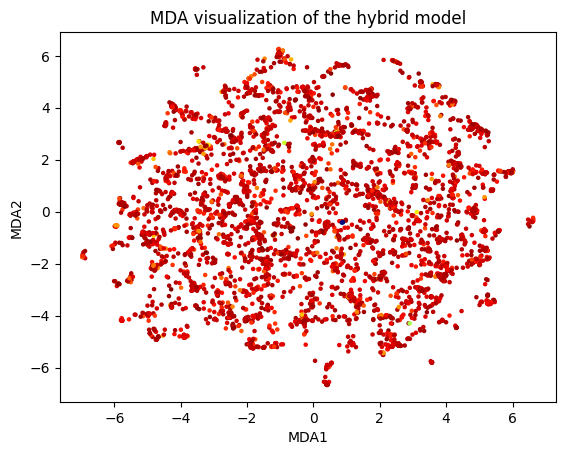

In [ ]:
# Apply MDA on the extracted features
neighborNum = 12
clusterIdx_train = discoverManifold(train_features_with_rbf, neighborNum)
Yreg_train = mda(train_features_with_rbf, clusterIdx_train)

# Plot the MDA results
plt.scatter(Yreg_train[:, 0], Yreg_train[:, 1], c=clusterIdx_train, cmap='jet', s=5)
plt.xlabel("MDA1")
plt.ylabel("MDA2")
plt.title('MDA visualization of the hybrid model')
plt.show()

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0
!pip install scikeras

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.6 MB/s eta 0:00:00
  Attempting uninstall: ten

In [ ]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Dropout
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM

# Load the data from a CSV file
data = pd.read_csv("/content/stressinput.csv", header=None)

# Split the data into features and labels
features = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# Scale the features using StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the CNN layers for feature extraction
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(train_features.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten()
])

# Reshape the data for CNN input
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Extract features using CNN layers
train_features_cnn = cnn_model.predict(train_features_cnn)
test_features_cnn = cnn_model.predict(test_features_cnn)

# Define the RBF network (same as provided)
# Define the RBF network
class RBFNet:
    def __init__(self, input_dim, output_dim, hidden_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.centers = None
        self.weights = None

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.hidden_dim)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Calculate the width parameter for the RBFs
        dmax = np.max([np.linalg.norm(self.centers[i] - self.centers[j]) for i in range(self.hidden_dim) for j in range(self.hidden_dim)])
        self.sigma = dmax / np.sqrt(2 * self.hidden_dim)

        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Solve for the weights using least squares regression
        self.weights = np.linalg.lstsq(X_transformed, y, rcond=None)[0]

    def predict(self, X):
        # Calculate the hidden layer activations
        X_transformed = np.zeros((X.shape[0], self.hidden_dim))
        for i in range(X.shape[0]):
            for j in range(self.hidden_dim):
                X_transformed[i, j] = self.rbf(X[i], self.centers[j])

        # Add a bias term to the hidden layer activations
        X_transformed = np.concatenate((X_transformed, np.ones((X.shape[0], 1))), axis=1)

        # Perform the prediction
        return np.dot(X_transformed, self.weights)

    def rbf(self, x, c):
        return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * self.sigma ** 2))

# Create the RBF network
rbf = RBFNet(input_dim=train_features_cnn.shape[1], output_dim=1, hidden_dim=50)

# Fit the RBF network on the CNN-extracted features
rbf.fit(train_features_cnn, train_labels)

# Predict using RBF network
train_rbf_predictions = rbf.predict(train_features_cnn)
test_rbf_predictions = rbf.predict(test_features_cnn)

# Concatenate RBF predictions with CNN-extracted features
train_features_with_rbf = np.concatenate((train_features_cnn, train_rbf_predictions.reshape(-1, 1)), axis=1)
test_features_with_rbf = np.concatenate((test_features_cnn, test_rbf_predictions.reshape(-1, 1)), axis=1)

# Reshape the data for Bi-LSTM input
train_features_with_rbf = train_features_with_rbf.reshape(train_features_with_rbf.shape[0], train_features_with_rbf.shape[1], 1)
test_features_with_rbf = test_features_with_rbf.reshape(test_features_with_rbf.shape[0], test_features_with_rbf.shape[1], 1)


# Function to create the Bi-LSTM model
def create_bi_lstm_model(units_lstm=64, units_dense=32, dropout_rate=0.2):
    model = Sequential([
        Bidirectional(LSTM(units_lstm, return_sequences=True), input_shape=(train_features_with_rbf.shape[1], 1)),
        Bidirectional(LSTM(units_lstm, return_sequences=True)),
        Bidirectional(LSTM(units_lstm)),
        Dense(units_dense, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create KerasClassifier for GridSearchCV
bi_lstm_classifier = KerasClassifier(build_fn=create_bi_lstm_model, epochs=5, batch_size=32, verbose=0)

# Define hyperparameters for grid search
param_grid = {
    'units_lstm': [32, 64, 128],
    'units_dense': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Perform grid search
grid = GridSearchCV(estimator=bi_lstm_classifier, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(train_features_with_rbf, train_labels)

# Summarize results
print("Best Accuracy: {:.2f}% using {}".format(grid_result.best_score_ * 100, grid_result.best_params_))

# Retrieve the best model
best_bi_lstm_model = grid_result.best_estimator_.model

# Evaluate the best model on the test data
test_loss, test_accuracy = best_bi_lstm_model.evaluate(test_features_with_rbf, test_labels)

print("\nBest Bi-LSTM Model:")
print("Test Accuracy:", test_accuracy)

# Use the best model for predictions
best_test_predictions = best_bi_lstm_model.predict(test_features_with_rbf)
best_test_predictions = (best_test_predictions > 0.5).astype(int)


36/36 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f34009b8550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1008, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1147, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mod